# Sim-Bench Results Analysis

This notebook provides comprehensive analysis of image similarity benchmark results.

**IMPORTANT**: Make sure to select the correct kernel:
- In Cursor: Click the kernel selector (top-right) → Select "Python (sim-bench)"
- In Jupyter: Kernel → Change kernel → "Python (sim-bench)"

## Features:
- Load and compare results across multiple experiments
- Visualize metric distributions
- Analyze per-query performance
- Compare methods side-by-side
- Inspect rankings and distances


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Imports successful!")


Imports successful!


In [16]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)


## 1. Load Results

First, let's find and load the most recent experiment results.


In [29]:
# Find all experiment directories
outputs_dir = Path('outputs')
experiment_dirs = sorted([d for d in outputs_dir.iterdir() if d.is_dir()], 
                        key=lambda x: x.stat().st_mtime, 
                        reverse=True)

print(f"Found {len(experiment_dirs)} experiment(s):\n")
for i, exp_dir in enumerate(experiment_dirs[:10]):
    methods = [m.name for m in exp_dir.iterdir() if m.is_dir()]
    print(f"{i+1}. {exp_dir.name}: {', '.join(methods)}")

# Select most recent experiment
if experiment_dirs:
    selected_exp = experiment_dirs[0]
    print(f"\n📊 Analyzing: {selected_exp.name}")
else:
    print("\nNo experiments found! Run a benchmark first.")


Found 68 experiment(s):

1. UK_Bench_100_grps: chi_square, deep, emd, sift_bovw
2. 2025-10-08_13-19-47: 
3. 2025-10-08_13-18-11: chi_square
4. Holidays_100_grps: chi_square, deep, emd, sift_bovw
5. 2025-10-08_11-25-34: chi_square, deep, emd, sift_bovw
6. 2025-10-08_11-14-19: chi_square, deep, emd, sift_bovw
7. 2025-10-08_11-07-41: chi_square, deep, emd, sift_bovw
8. 2025-10-08_09-49-57: 
9. 2025-10-08_09-17-50: 
10. 2025-10-08_09-16-51: 

📊 Analyzing: UK_Bench_100_grps


In [30]:
selected_exp

WindowsPath('outputs/UK_Bench_100_grps')

In [18]:
# Or manually select a specific experiment
# selected_exp = Path('outputs/2025-10-08_10-30-45')

print(f"Selected experiment: {selected_exp}")
print(f"\nAvailable methods:")
method_dirs = [d for d in selected_exp.iterdir() if d.is_dir()]
for method_dir in method_dirs:
    print(f"  - {method_dir.name}")


Selected experiment: outputs\2025-10-08_13-25-09

Available methods:
  - chi_square
  - deep
  - emd
  - sift_bovw


## 2. Load Summary Results

Load the summary CSV if available, or aggregate individual method results.


In [38]:
# selected_exp = Path('outputs', 'UK_Bench_100_grps')

selected_exp = Path('outputs', 'Holidays_100_grps')


In [39]:
# Try to load summary CSV
summary_file = selected_exp / 'summary.csv'

if summary_file.exists():
    summary_df = pd.read_csv(summary_file)
    print("Summary loaded from summary.csv")
else:
    # Aggregate from individual method results
    print("No summary.csv found, aggregating from individual methods...")
    method_results = []
    
    for method_dir in method_dirs:
        metrics_file = method_dir / 'metrics.csv'
        if metrics_file.exists():
            df = pd.read_csv(metrics_file)
            method_results.append(df)
    
    if method_results:
        summary_df = pd.concat(method_results, ignore_index=True)
    else:
        summary_df = pd.DataFrame()

# Display summary
if not summary_df.empty:
    print(f"\n📊 Summary Results ({len(summary_df)} methods):\n")
    display(summary_df)
else:
    print("No results found!")


Summary loaded from summary.csv

📊 Summary Results (4 methods):



,method,ns,recall@1,recall@4,map@10,num_queries,num_images
0,chi_square,1.273723,0.667883,0.799270,0.613050,274,274
1,emd,0.843066,0.456204,0.627737,0.393602,274,274
2,deep,1.905109,0.919708,0.970803,0.905252,274,274
3,sift_bovw,1.156934,0.580292,0.715328,0.534706,274,274


## 3. Compare Methods

Visual comparison of different methods across metrics.


Available metrics: ns, recall@1, recall@4, map@10


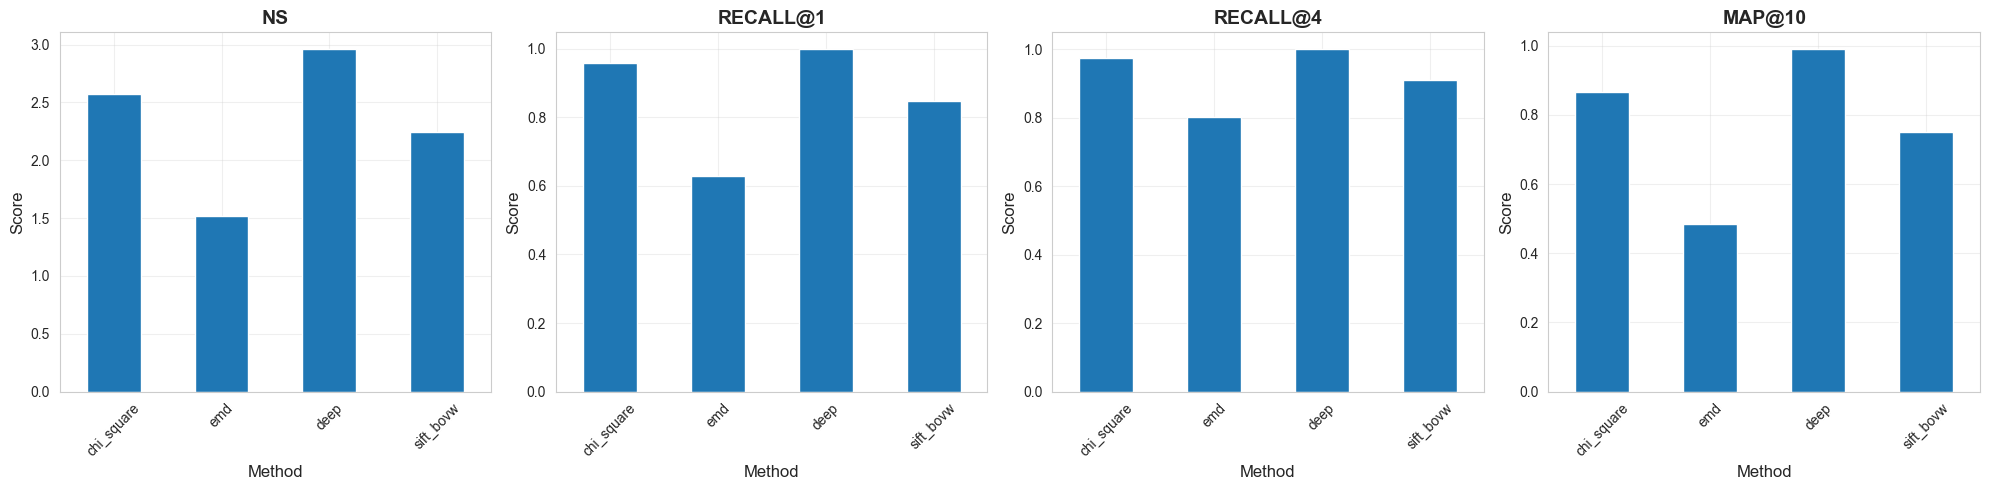


🏆 Method Ranking:

NS:
  deep           : 2.9575
  chi_square     : 2.5700
  sift_bovw      : 2.2450
  emd            : 1.5150

RECALL@1:
  deep           : 0.9975
  chi_square     : 0.9575
  sift_bovw      : 0.8475
  emd            : 0.6275

RECALL@4:
  deep           : 1.0000
  chi_square     : 0.9750
  sift_bovw      : 0.9100
  emd            : 0.8025

MAP@10:
  deep           : 0.9894
  chi_square     : 0.8650
  sift_bovw      : 0.7511
  emd            : 0.4857


In [20]:
if not summary_df.empty:
    # Identify available metrics (exclude metadata columns)
    exclude_cols = ['method', 'num_queries', 'num_gallery', 'num_images', 'created_at']
    metric_cols = [col for col in summary_df.columns if col not in exclude_cols]
    
    print(f"Available metrics: {', '.join(metric_cols)}")
    
    # Plot comparison
    if len(metric_cols) > 0:
        fig, axes = plt.subplots(1, min(len(metric_cols), 4), figsize=(5*min(len(metric_cols), 4), 5))
        if not isinstance(axes, np.ndarray):
            axes = [axes]
        
        for ax, metric in zip(axes, metric_cols[:4]):
            summary_df.plot(x='method', y=metric, kind='bar', ax=ax, legend=False)
            ax.set_title(f'{metric.upper()}', fontsize=14, fontweight='bold')
            ax.set_ylabel('Score', fontsize=12)
            ax.set_xlabel('Method', fontsize=12)
            ax.tick_params(axis='x', rotation=45)
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    # Print ranking
    print("\n🏆 Method Ranking:")
    print("=" * 60)
    for metric in metric_cols[:4]:
        ranked = summary_df.sort_values(metric, ascending=False)
        print(f"\n{metric.upper()}:")
        for idx, row in ranked.iterrows():
            print(f"  {row['method']:15s}: {row[metric]:.4f}")


## 4. Per-Query Analysis

Analyze per-query performance to identify strengths and weaknesses.


In [21]:
# Select a method to analyze
if method_dirs:
    method_to_analyze = method_dirs[0].name
    print(f"Analyzing method: {method_to_analyze}")
    print(f"(Change method_to_analyze variable to analyze a different method)\n")
    
    # Load per-query results
    per_query_file = selected_exp / method_to_analyze / 'per_query.csv'
    
    if per_query_file.exists():
        per_query_df = pd.read_csv(per_query_file)
        print(f"Loaded {len(per_query_df)} query results\n")
        display(per_query_df.head(10))
    else:
        print("No per_query.csv found for this method")
        per_query_df = None
else:
    per_query_df = None


Analyzing method: chi_square
(Change method_to_analyze variable to analyze a different method)

Loaded 400 query results



,query_idx,query_path,group_id,ns_hitcount@4,ap@10
0,0,D:\Similar Images\DataSets\ukbench\full\ukbench00000.jpg,0,2,0.809524
1,1,D:\Similar Images\DataSets\ukbench\full\ukbench00001.jpg,0,3,0.916667
2,2,D:\Similar Images\DataSets\ukbench\full\ukbench00002.jpg,0,3,1.000000
3,3,D:\Similar Images\DataSets\ukbench\full\ukbench00003.jpg,0,3,1.000000
4,4,D:\Similar Images\DataSets\ukbench\full\ukbench00004.jpg,1,3,1.000000
5,5,D:\Similar Images\DataSets\ukbench\full\ukbench00005.jpg,1,3,1.000000
6,6,D:\Similar Images\DataSets\ukbench\full\ukbench00006.jpg,1,1,0.591667
7,7,D:\Similar Images\DataSets\ukbench\full\ukbench00007.jpg,1,3,1.000000
8,8,D:\Similar Images\DataSets\ukbench\full\ukbench00008.jpg,2,2,0.666667
9,9,D:\Similar Images\DataSets\ukbench\full\ukbench00009.jpg,2,1,0.428571


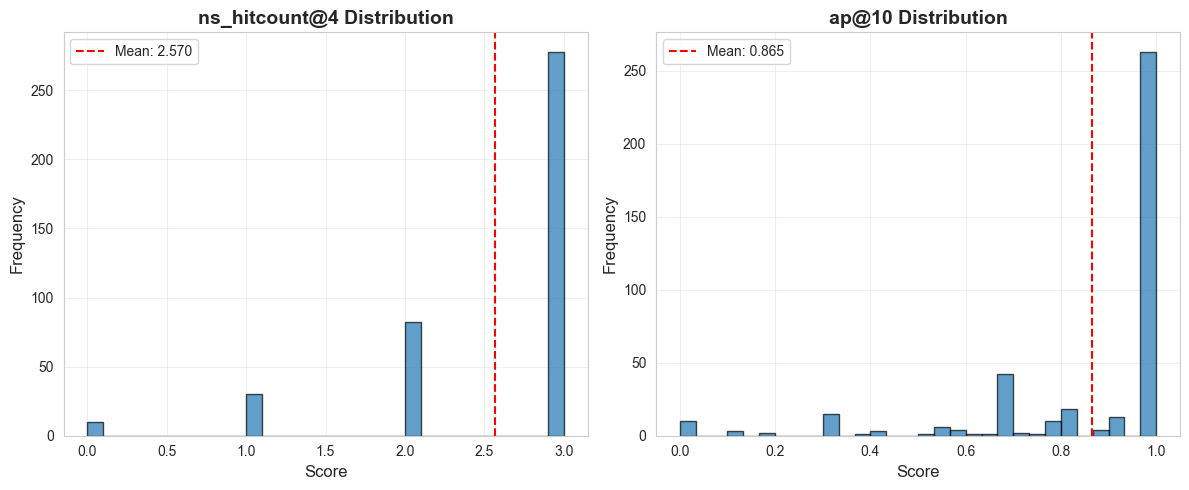


📈 Per-Query Statistics:


,ns_hitcount@4,ap@10
count,400.000000,400.000000
mean,2.570000,0.865041
std,0.739233,0.239791
min,0.000000,0.000000
25%,2.000000,0.791667
50%,3.000000,1.000000
75%,3.000000,1.000000
max,3.000000,1.000000


In [22]:
# Visualize per-query metrics distribution
if per_query_df is not None and not per_query_df.empty:
    # Identify numeric metric columns
    exclude_cols = ['query_idx', 'query_path', 'group_id', 'num_relevant']
    metric_cols = [col for col in per_query_df.columns 
                   if col not in exclude_cols and per_query_df[col].dtype in ['float64', 'int64']]
    
    if metric_cols:
        n_metrics = min(len(metric_cols), 4)
        fig, axes = plt.subplots(1, n_metrics, figsize=(6*n_metrics, 5))
        if n_metrics == 1:
            axes = [axes]
        
        for ax, metric in zip(axes, metric_cols[:4]):
            per_query_df[metric].hist(bins=30, ax=ax, edgecolor='black', alpha=0.7)
            ax.set_title(f'{metric} Distribution', fontsize=14, fontweight='bold')
            ax.set_xlabel('Score', fontsize=12)
            ax.set_ylabel('Frequency', fontsize=12)
            ax.axvline(per_query_df[metric].mean(), color='red', linestyle='--', 
                      label=f'Mean: {per_query_df[metric].mean():.3f}')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Statistics
        print("\n📈 Per-Query Statistics:")
        print("=" * 60)
        display(per_query_df[metric_cols].describe())


## 5. Identify Best and Worst Queries

Find queries where the method performs exceptionally well or poorly.


In [23]:
if per_query_df is not None and not per_query_df.empty and metric_cols:
    # Pick primary metric
    analysis_metric = metric_cols[0]
    
    # Best queries
    print(f"\n🏆 Top 10 Queries ({analysis_metric}):")
    print("=" * 80)
    best_queries = per_query_df.nlargest(10, analysis_metric)
    display(best_queries[['query_idx', 'query_path', analysis_metric]])
    
    # Worst queries
    print(f"\n⚠️ Bottom 10 Queries ({analysis_metric}):")
    print("=" * 80)
    worst_queries = per_query_df.nsmallest(10, analysis_metric)
    display(worst_queries[['query_idx', 'query_path', analysis_metric]])



🏆 Top 10 Queries (ns_hitcount@4):


,query_idx,query_path,ns_hitcount@4
1,1,D:\Similar Images\DataSets\ukbench\full\ukbench00001.jpg,3
2,2,D:\Similar Images\DataSets\ukbench\full\ukbench00002.jpg,3
3,3,D:\Similar Images\DataSets\ukbench\full\ukbench00003.jpg,3
4,4,D:\Similar Images\DataSets\ukbench\full\ukbench00004.jpg,3
5,5,D:\Similar Images\DataSets\ukbench\full\ukbench00005.jpg,3
7,7,D:\Similar Images\DataSets\ukbench\full\ukbench00007.jpg,3
12,12,D:\Similar Images\DataSets\ukbench\full\ukbench00012.jpg,3
13,13,D:\Similar Images\DataSets\ukbench\full\ukbench00013.jpg,3
14,14,D:\Similar Images\DataSets\ukbench\full\ukbench00014.jpg,3
15,15,D:\Similar Images\DataSets\ukbench\full\ukbench00015.jpg,3



⚠️ Bottom 10 Queries (ns_hitcount@4):


,query_idx,query_path,ns_hitcount@4
22,22,D:\Similar Images\DataSets\ukbench\full\ukbench00022.jpg,0
38,38,D:\Similar Images\DataSets\ukbench\full\ukbench00038.jpg,0
136,136,D:\Similar Images\DataSets\ukbench\full\ukbench00136.jpg,0
212,212,D:\Similar Images\DataSets\ukbench\full\ukbench00212.jpg,0
230,230,D:\Similar Images\DataSets\ukbench\full\ukbench00230.jpg,0
295,295,D:\Similar Images\DataSets\ukbench\full\ukbench00295.jpg,0
296,296,D:\Similar Images\DataSets\ukbench\full\ukbench00296.jpg,0
336,336,D:\Similar Images\DataSets\ukbench\full\ukbench00336.jpg,0
344,344,D:\Similar Images\DataSets\ukbench\full\ukbench00344.jpg,0
350,350,D:\Similar Images\DataSets\ukbench\full\ukbench00350.jpg,0


## 6. Load and Analyze Experiment Logs

Read the experiment logs to understand configuration and execution.


In [24]:
# Load experiment log
exp_log_file = selected_exp / 'experiment.log'

if exp_log_file.exists():
    with open(exp_log_file, 'r', encoding='utf-8') as f:
        log_lines = f.readlines()
    
    print(f"Experiment Log ({len(log_lines)} lines):\n")
    print("=" * 80)
    
    # Show first 30 lines
    for line in log_lines[:30]:
        print(line.rstrip())
    
    if len(log_lines) > 30:
        print(f"\n... ({len(log_lines) - 30} more lines)")
else:
    print("No experiment.log found")


Experiment Log (61 lines):

2025-10-08 13:25:09 - sim_bench - INFO - ================================================================================
2025-10-08 13:25:09 - sim_bench - INFO - EXPERIMENT START
2025-10-08 13:25:09 - sim_bench - INFO - ================================================================================
2025-10-08 13:25:09 - sim_bench - INFO - Dataset: ukbench
2025-10-08 13:25:09 - sim_bench - INFO - Methods: ['chi_square', 'emd', 'deep', 'sift_bovw']
2025-10-08 13:25:09 - sim_bench - INFO - Metrics: ['ns', 'recall@1', 'recall@4', 'map@10']
2025-10-08 13:25:09 - sim_bench - INFO - Sampling: {'max_groups': 100, 'max_queries': None, 'random_seed': 42}
2025-10-08 13:25:09 - sim_bench - INFO - Caching: True
2025-10-08 13:25:09 - sim_bench - INFO - ================================================================================
2025-10-08 13:25:09 - sim_bench - INFO - Loading dataset: ukbench
2025-10-08 13:25:09 - sim_bench - INFO - Applying sampling: {'max_groups':

## 7. Advanced: Compare All Methods

Heatmap comparing all methods across all metrics.


In [25]:
if not summary_df.empty and len(metric_cols) > 1:
    # Create normalized comparison (0-1 scale for each metric)
    comparison_df = summary_df.copy()
    
    for metric in metric_cols:
        if metric in comparison_df.columns:
            min_val = comparison_df[metric].min()
            max_val = comparison_df[metric].max()
            if max_val > min_val:
                comparison_df[f'{metric}_normalized'] = (comparison_df[metric] - min_val) / (max_val - min_val)
    
    # Heatmap
    normalized_cols = [col for col in comparison_df.columns if col.endswith('_normalized')]
    if normalized_cols:
        heatmap_data = comparison_df[['method'] + normalized_cols].set_index('method')
        heatmap_data.columns = [col.replace('_normalized', '') for col in heatmap_data.columns]
        
        plt.figure(figsize=(10, len(summary_df) * 0.8))
        sns.heatmap(heatmap_data.T, annot=True, fmt='.3f', cmap='RdYlGn', 
                    cbar_kws={'label': 'Normalized Score (0-1)'}, linewidths=0.5)
        plt.title('Method Comparison Heatmap (Normalized)', fontsize=14, fontweight='bold')
        plt.xlabel('Method', fontsize=12)
        plt.ylabel('Metric', fontsize=12)
        plt.tight_layout()
        plt.show()


## 8. Custom Analysis

Add your own analysis below. Some ideas:
- Load detailed.log for debugging
- Analyze specific query failures
- Compare different configurations
- Export publication-ready figures


In [26]:
# Your custom analysis here
# Example: Load detailed log for debugging

detailed_log_file = selected_exp / 'detailed.log'

if detailed_log_file.exists():
    print("✓ Detailed log available!")
    print("  Load it with: open(detailed_log_file, 'r').read()")
else:
    print("No detailed.log (enable with logging.detailed: true in config)")


No detailed.log (enable with logging.detailed: true in config)
